# Introduction to Dataset 

The dataset consists of 10 000 data points stored as rows with 14 features in columns
UID: unique identifier ranging from 1 to 10000
product ID: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
torque [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. 
tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes
tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail 

# Business Understanding




1. *Determine the type of failure*

# Data Understanding

In [815]:
# Data wrangling
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Resampling
from imblearn.over_sampling import SMOTENC

#Dimension Reduction
from sklearn.decomposition import PCA

# Preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Models Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model evaluation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Save model
import pickle


In [761]:
## Upload df
df = pd.read_csv(r'C:\Users\eng.fitness69\Documents\predictive_maintenance\predictive_maintenance.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


In [762]:
# Verify if the data has duplicate values or null values.
data_duplicates = df.duplicated().sum()
data_null = df.isnull().sum().sum()

print("Total duplicated values ", data_duplicates)
print("Total missing values: ", data_null)

Total duplicated values  0
Total missing values:  0


In [763]:
## Verify the data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [764]:
## Numeric features analysis
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [765]:
## Verify the proportion of column "Target"
df.Target.value_counts()

0    9661
1     339
Name: Target, dtype: int64

In [766]:
## Verify the proportion of column "Failure_type"
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

How can be see, we dont have proportion in the column "Failure_type" distribution. As our business object is classifier the type of failure, lets remove failures classified as "Random Failures". This approach will help the model to classify the know failures and minimize the unbalanced classes.

In [767]:
df = df.loc[df['Failure Type'] != 'Random Failures']

# Data Preparation


In [768]:
## Rename the columns (dont needed, but i like change for my custom)

rename_columns = {
    
    'UDI':'ID',
    'Air temperature [K]': 'Air_temperature',
    'Process temperature [K]' : 'Process_temperature',
    'Rotational speed [rpm]' : 'Rotational_speed',
    'Torque [Nm]' : 'Torque',
    'Tool wear [min]' : 'Tool_wear',
    'Product ID' : 'Product_ID',
    'Failure Type': 'Failure_type'    
    
}

df.rename(rename_columns, axis = 1, inplace = True)

C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\960337566.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(rename_columns, axis = 1, inplace = True)


In [769]:
## Regarding to introduction of dataset, we don't need ID and Product_ID columns for us business objective, so lets remove this.

drop_columns = ["ID", "Product_ID"]

df.drop(drop_columns, axis = 1, inplace = True)

C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\447981689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(drop_columns, axis = 1, inplace = True)


In [770]:
## Change de type of "Rotational_speed" and "Tool_wear" columns to "float"
df['Rotational_speed'] = df['Rotational_speed'].astype('float')
df['Tool_wear'] = df['Tool_wear'].astype('float')


C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\2128750473.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Rotational_speed'] = df['Rotational_speed'].astype('float')
C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\2128750473.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tool_wear'] = df['Tool_wear'].astype('float')


In [771]:
# I prefer rename the categories L, M and H to be more cleareful what each one represents
rename_type = {
    'L':'Low',
    'M':'Medium',
    'H':'High'
}

df['Type'].replace(rename_type, inplace = True)

C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\2298621566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'].replace(rename_type, inplace = True)


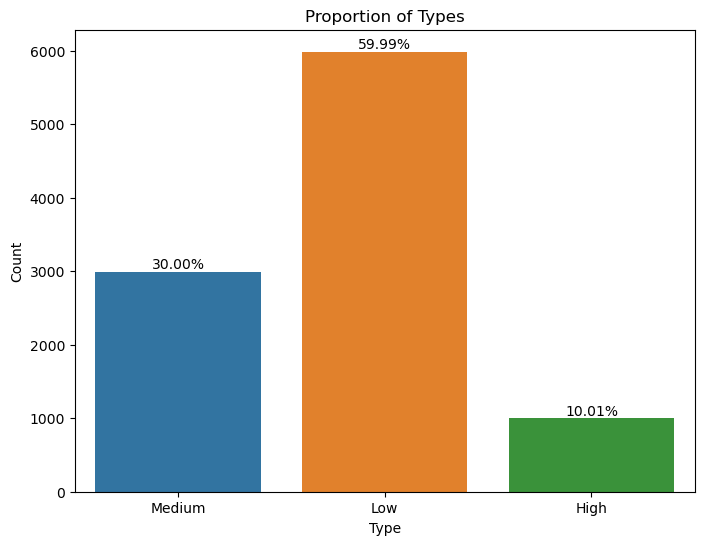

In [772]:
# Count types
tipo_contagem = df['Type'].value_counts()

# Show graphic
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Type')
plt.title('Proportion of Types')
plt.xlabel('Type')
plt.ylabel('Count')

# Add as percentages as labels
total = len(df['Type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

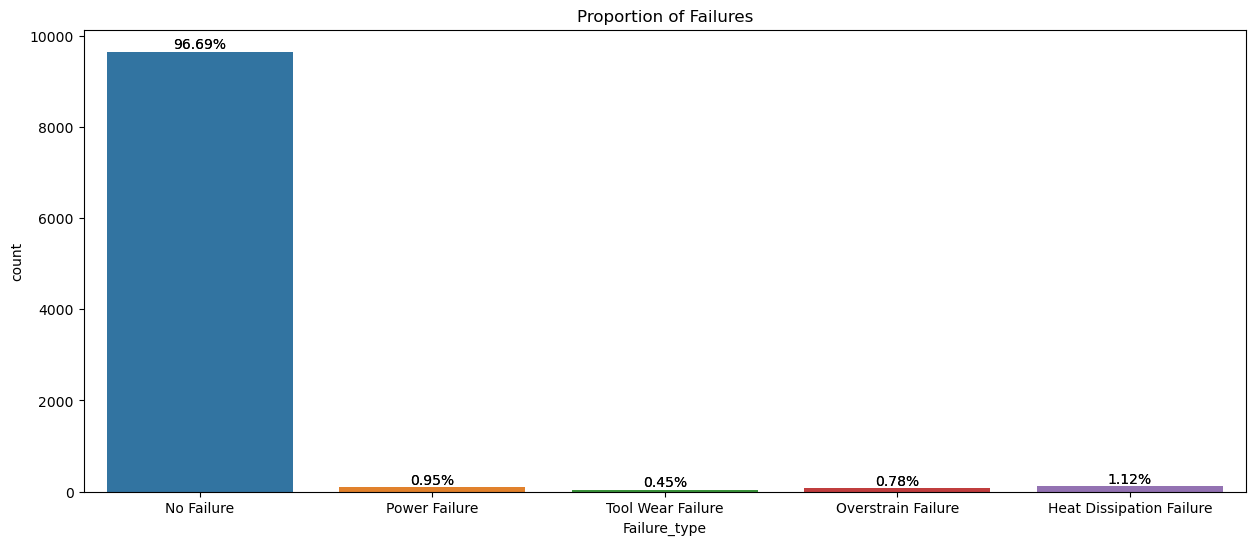

In [773]:
# Count types
tipo_contagem = df['Failure_type'].value_counts()

# Plot bar graphic
plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df, x='Failure_type')
plt.title('Proportion of Failures')
plt.xlabel('Type')
plt.ylabel('Count')

ax = sns.countplot(data=df, x = 'Failure_type')

# Add as percentages as labels
total = len(df['Failure_type'])
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total) * 100
    ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

plt.show()

REESCREVER ISSO AQUI TUDO DNV

As i've mencioned , we have a problem with this target column, the column hasn't proporcional distribution and has only "Random Failures", so i will delete this and i need apply the over sampling - Smote in the rest of df.

In [774]:
# df.drop(df[df['Failure_type'] == 'Random Failures'].index, inplace=True)

In [775]:
# Analysing redundance value, count failures on "Target" column
count_failures = (df['Target'] == 1).sum()
print('Número de falhas:', count_failures)

# Sum of occurrences of 'Failure_type' other than 'No Failure'
sum_failures = df.loc[(df['Failure_type'] != 'No Failure') & (df['Target'] == 1), 'Failure_type'].count()
print('Soma das falhas de tipo diferente de "No Failure":', sum_failures)

Número de falhas: 339
Soma das falhas de tipo diferente de "No Failure": 330


In [776]:
## 9 data is ambiguous, so we need remove this.

# Filter the rows with has 1 in the column "Target" and 'No Failure' in the column 'Failure_type'
rows_to_remove = df[(df['Target'] == 1) & (df['Failure_type'] == 'No Failure')]

# Remove this filtered row in the main df
df.drop(rows_to_remove.index, inplace=True)

C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\1407886932.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(rows_to_remove.index, inplace=True)


In [777]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9973 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 9973 non-null   object 
 1   Air_temperature      9973 non-null   float64
 2   Process_temperature  9973 non-null   float64
 3   Rotational_speed     9973 non-null   float64
 4   Torque               9973 non-null   float64
 5   Tool_wear            9973 non-null   float64
 6   Target               9973 non-null   int64  
 7   Failure_type         9973 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 701.2+ KB


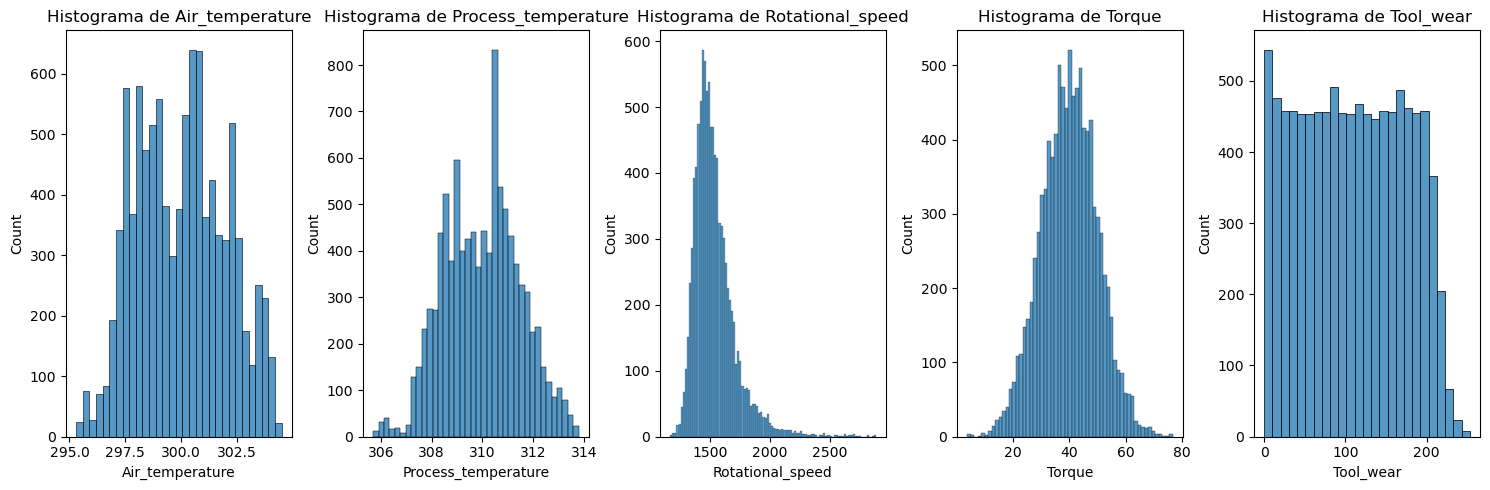

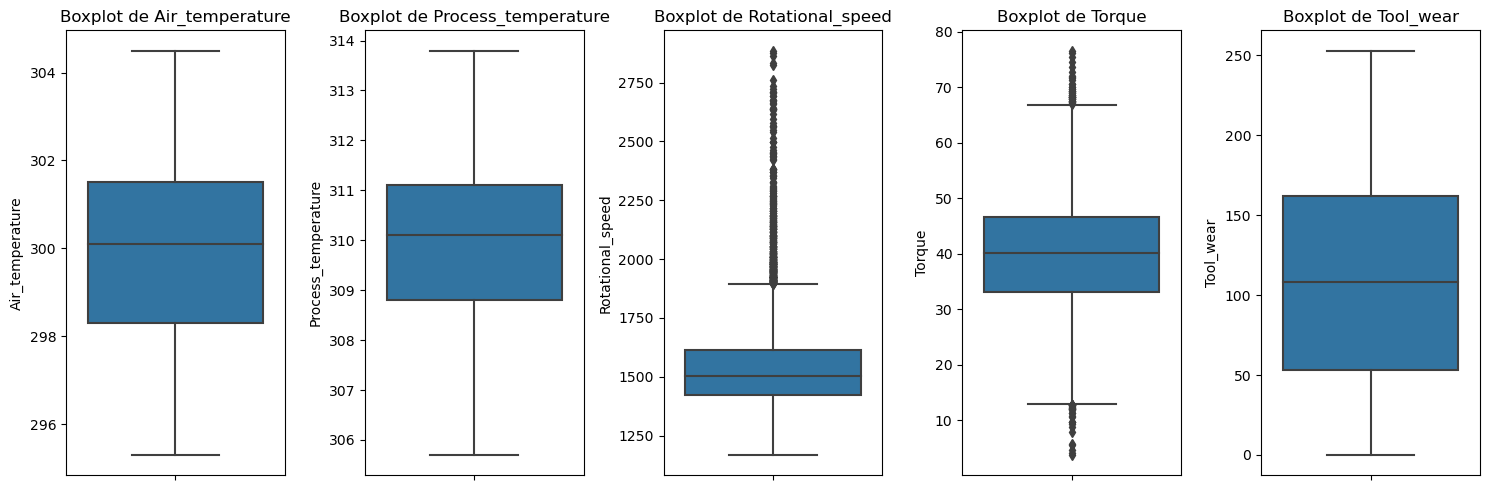

In [778]:
NUMERIC_FEATURES = ['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque', 'Tool_wear']
CATEGORIC_FEATURES = ['Type']

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot histograms 
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.histplot(data=df, x=feature, ax=axes[i])
    axes[i].set_title(f'Histograma de {feature}')

# Adjust subplot 
plt.tight_layout()

# Show histogram 
plt.show()

# Create the figure and axess
fig, axes = plt.subplots(nrows=1, ncols=len(NUMERIC_FEATURES), figsize=(15, 5))

# Plot boxplot side by side
for i, feature in enumerate(NUMERIC_FEATURES):
    sns.boxplot(data=df, y=feature, ax=axes[i])
    axes[i].set_title(f'Boxplot de {feature}')

# Adjust subplot
plt.tight_layout()

# Show boxplots
plt.show()



How can i see, maybe we have some outliers in the "Rotational_speed" and "Torque" columns, but we cant remove this now. Its necessary avaliate better.

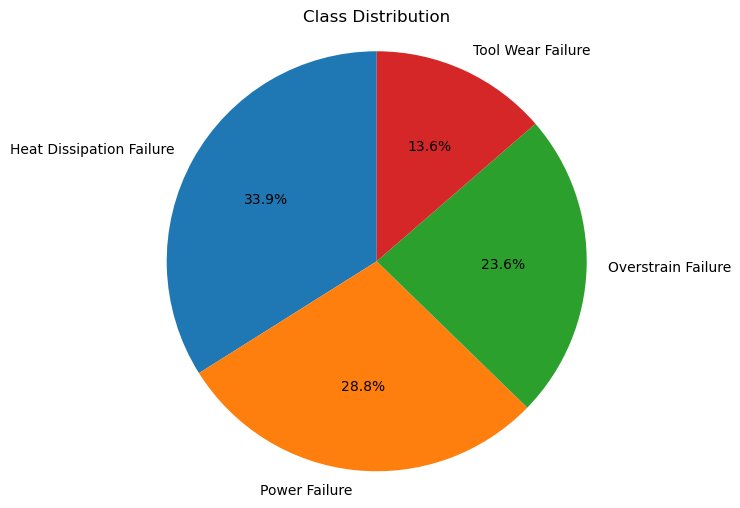

In [779]:
df_failure_type = df.loc[df['Failure_type'] != "No Failure"]
# Verifique o balanceamento resultante
proportions = df_failure_type['Failure_type'].value_counts(normalize=True)


# Plotar o gráfico de pizza
plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Assegura que o gráfico seja desenhado como um círculo
plt.title('Class Distribution')
plt.show()

In [780]:
df.drop('Target', axis = 1, inplace = True)

C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\1221844721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Target', axis = 1, inplace = True)


C:\Users\eng.fitness69\AppData\Local\Temp\ipykernel_11924\3786389366.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

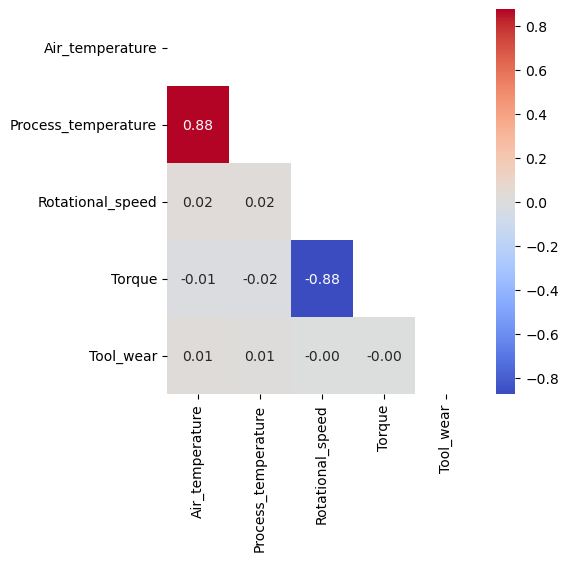

In [781]:
corr = df.corr()
plt.figure(figsize = (5,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot = True, mask=mask, cmap = 'coolwarm', fmt = ".2f")


In [782]:
#create preprocessor ColumnTransformer to do OneHotEncoder for CATEGORIC_FEATURES and StandardScaler() for NUMERIC_FEATURES

# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_trans', num_pipeline, NUMERIC_FEATURES),
    ('cat_trans', cat_pipeline, CATEGORIC_FEATURES)
])

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Converting the transformed data back to a dataframe for easier visualization
# The transformed data will have new column names, especially for the one hot encoded categories
encoded_feature_names = preprocessor.named_transformers_['cat_trans'].get_feature_names_out(CATEGORIC_FEATURES)
new_column_names = list(NUMERIC_FEATURES) + list(encoded_feature_names)

df_transformed = pd.DataFrame(df_transformed, columns=new_column_names)

df_transformed.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Type_High,Type_Low,Type_Medium
0,-0.951417,-0.946356,0.067484,0.283054,-1.695647,0.0,0.0,1.0
1,-0.901428,-0.878954,-0.729604,0.634238,-1.648511,0.0,1.0,0.0
2,-0.951417,-1.013759,-0.227940,0.945286,-1.617087,0.0,1.0,0.0
3,-0.901428,-0.946356,-0.590253,-0.048061,-1.585664,0.0,1.0,0.0
4,-0.901428,-0.878954,-0.729604,0.002108,-1.554240,0.0,1.0,0.0


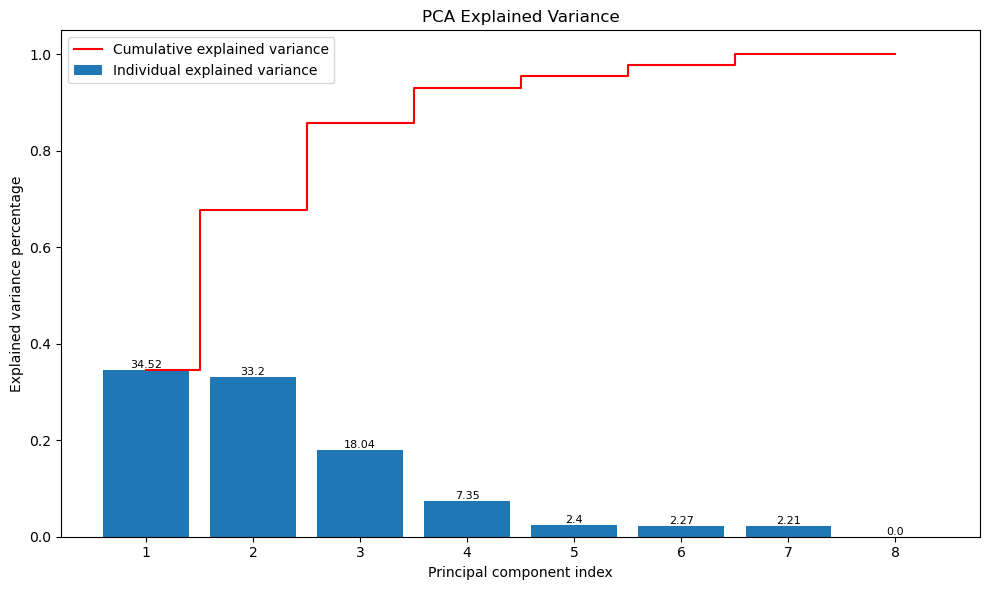

In [783]:
# Realizar PCA
pca = PCA()
pca.fit(df_transformed)  # Assumindo que df_transformed é o seu DataFrame transformado

# Variância explicada
exp_var = pca.explained_variance_ratio_
cum_exp_var = exp_var.cumsum()

# Número de componentes do PCA
n_pca_components = len(exp_var)

# Criar o gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, n_pca_components + 1), exp_var, align='center',
               label='Individual explained variance')
plt.step(range(1, n_pca_components + 1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

# Adicionar rótulos de dados em cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval*100, 2), 
             va='bottom', ha='center', fontsize=8)

# Ajuste dos demais elementos do gráfico
plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, n_pca_components + 1)))
plt.title('PCA Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

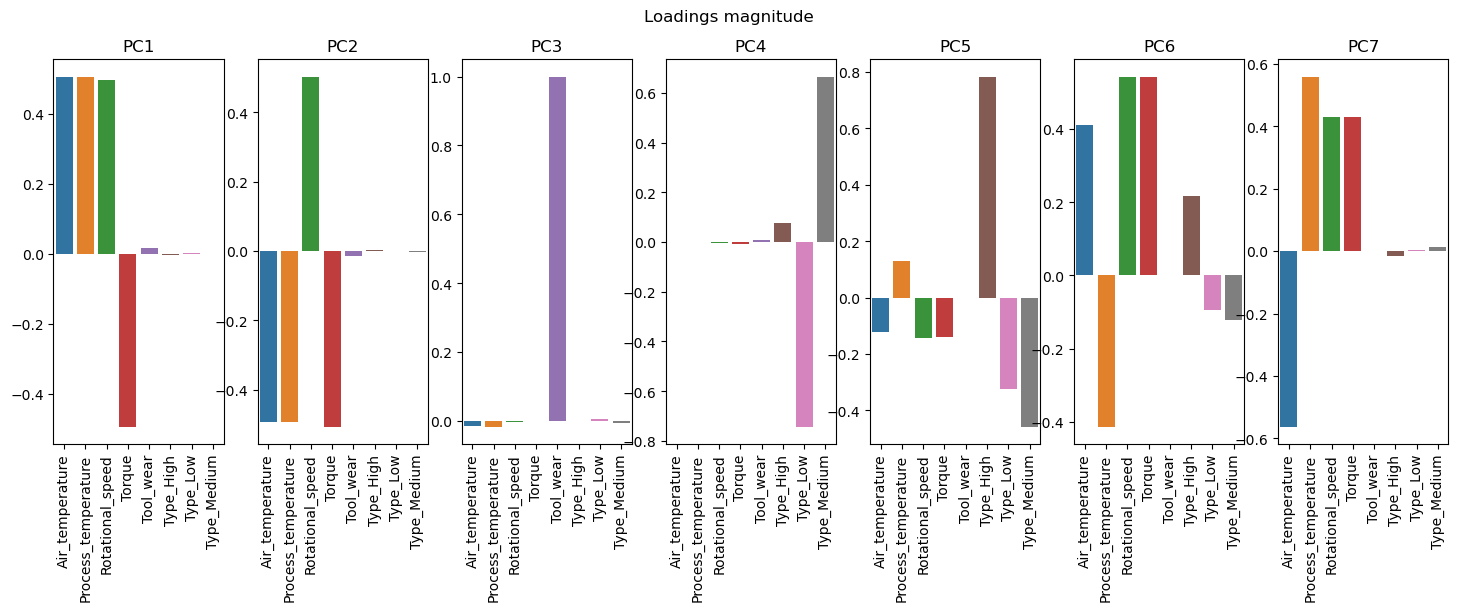

In [784]:
# Realizar PCA com 5 componentes
pca4 = PCA(n_components=7)
X_pca4 = pd.DataFrame(data=pca4.fit_transform(df_transformed), columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7'])

# Análise de Loadings
fig, axs = plt.subplots(ncols=7, figsize=(18,5))
fig.suptitle('Loadings magnitude')

# Certifique-se de que a lista de nomes de colunas seja a correta após a transformação do OneHotEncoder
all_features = NUMERIC_FEATURES + list(encoded_feature_names)  # Use encoded_feature_names do OneHotEncoder
pca_loadings = pd.DataFrame(data=pca4.components_, columns=all_features)

for j in range(7):
    ax = axs[j]
    sns.barplot(ax=ax, x=pca_loadings.columns, y=pca_loadings.values[j])
    ax.tick_params(axis='x', rotation=90)
    ax.title.set_text('PC'+str(j+1))

plt.show()


In [785]:
df.Failure_type.unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Heat Dissipation Failure'], dtype=object)

# Modeling


In this section, we will test various techniques to address imbalanced classes, as observed in our dataset. We aim to evaluate the performance of models both with and without the use of PCA. Additionally, we will employ SMOTE-NC to manage class imbalance and explore the use of hyperparameters within the model to balance classes without utilizing SMOTE-NC. After determining which approach most effectively enhances model performance, we will proceed to tune the model with GridSearchCV. Beyond developing the best model, this section also tests various techniques, such as building preprocessors and pipelines, to streamline the code and make the modeling process more efficient.

In [806]:
## -- Functions - ##
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Balanced Accuracy': balanced_accuracy_score(y_true, y_pred),
        'Macro Recall': recall_score(y_true, y_pred, average='macro'),
        'Macro Precision': precision_score(y_true, y_pred, average='macro'),
        'Macro F1': f1_score(y_true, y_pred, average='macro')
    }
    return dict_metrics

It average = 'macro'. When applying this method to calculate metrics, we have a better approach to evaluating the model because this parameter calculates the F1 score for each class individually. If we use "weighted," for instance, the metric is calculated considering the weighted metrics; hence, the majority class has more influence on the result of this metric. In our scenario, the majority class is 'No Failures', and it's easier to simply predict that the machine will not fail. When considering the importance of correctly classifying the types of failures, it's crucial to remember that the model needs to perform well for all classes independently. Therefore, let's examine the model's metrics using average = 'macro'.

In [807]:
# Now that we knows the number of component that explain our data, lets create a copy of our dataset and build the pipelines.
# Until preparare the pipeline to scale numeric value (StandardScaler/MinMaxScaler for example) and OneHotEncoder for
# the categorical columns and deals with inbalance data, its indispensable separeted the dataset between train and test
# to prevent data leakage.
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Testing modeling with balancing class with hiper paramters by models. To validate this, we'll consider the metric f1-score

In [808]:
# Creating preprocessor

num_pip_model = Pipeline(steps=[
    ('num_pip_model', StandardScaler())
])

cat_pip_model = Pipeline(steps=[
    ('cat_pip_model', OneHotEncoder())
])

preprocessor_model = ColumnTransformer(transformers=[
    ('num_prep_model', num_pip_model, NUMERIC_FEATURES),
    ('cat_prep_model', cat_pip_model, CATEGORIC_FEATURES)
])

pip_model = Pipeline(steps=[
    ('preprocessor', preprocessor_model),
    ('pca', PCA(n_components= 4)),
    ('model', LogisticRegressionCV(class_weight='balanced'))
])

pip_model.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_prep_model',
                                                  Pipeline(steps=[('num_pip_model',
                                                                   StandardScaler())]),
                                                  ['Air_temperature',
                                                   'Process_temperature',
                                                   'Rotational_speed', 'Torque',
                                                   'Tool_wear']),
                                                 ('cat_prep_model',
                                                  Pipeline(steps=[('cat_pip_model',
                                                                   OneHotEncoder())]),
                                                  ['Type'])])),
                ('pca', PCA(n_components=4)),
                ('model', LogisticRegressionCV(class_weight='balanced'))])

In [809]:
# Step 1: Generate Predictions
y_pred = pip_model.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.45664160401002507,
 'Balanced Accuracy': 0.6554240840921286,
 'Macro Recall': 0.6554240840921286,
 'Macro Precision': 0.27906855642553996,
 'Macro F1': 0.25155969095538055}

In [810]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [811]:
# Creating preprocessor

num_pip_model = Pipeline(steps=[
    ('num_pip_model', StandardScaler())
])

cat_pip_model = Pipeline(steps=[
    ('cat_pip_model', OneHotEncoder())
])

preprocessor_model = ColumnTransformer(transformers=[
    ('num_prep_model', num_pip_model, NUMERIC_FEATURES),
    ('cat_prep_model', cat_pip_model, CATEGORIC_FEATURES)
])

pip_model = Pipeline(steps=[
    ('preprocessor', preprocessor_model),
    ('model', LogisticRegressionCV(class_weight='balanced'))
])

pip_model.fit(X_train, y_train)



c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_prep_model',
                                                  Pipeline(steps=[('num_pip_model',
                                                                   StandardScaler())]),
                                                  ['Air_temperature',
                                                   'Process_temperature',
                                                   'Rotational_speed', 'Torque',
                                                   'Tool_wear']),
                                                 ('cat_prep_model',
                                                  Pipeline(steps=[('cat_pip_model',
                                                                   OneHotEncoder())]),
                                                  ['Type'])])),
                ('model', LogisticRegressionCV(class_weight='balanced'))])

In [812]:
# Step 1: Generate Predictions
y_pred = pip_model.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.8741854636591478,
 'Balanced Accuracy': 0.9649889250200292,
 'Macro Recall': 0.9649889250200292,
 'Macro Precision': 0.4632776240153289,
 'Macro F1': 0.5586819920172443}

Critical Information in Dropped Components: The 7% variance not captured by PCA might contain crucial information for your model. This is particularly true for complex datasets where small but important details might be critical for accurate predictions.

Non-linear Relationships: PCA is a linear dimensionality reduction technique. If your data contains non-linear relationships that are important for predictions, PCA might not be able to capture these effectively, leading to a decrease in model performance.

Model-Data Compatibility: Some models are more sensitive to the input feature representation and may perform better with the original features rather than the principal components. This can be due to various reasons, including the type of algorithm, the nature of the data, and the specific task at hand.

Importance of Feature Interactions: If interactions between original features are important for your model, PCA, which creates linear combinations of features, might disrupt these interactions

Is It Problematic?
Not necessarily. It's important to remember that PCA is just one of many tools for dimensionality reduction and feature extraction. If PCA is not improving or is even worsening your model's performance, it's entirely reasonable to choose not to use it.

In [813]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [820]:

# Assuming NUMERIC_FEATURES and CATEGORIC_FEATURES are defined

# Pipelines for numeric and categorical features
num_pip_model = Pipeline(steps=[
    ('scaler', StandardScaler())
])

cat_pip_model = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

# Combined preprocessor
preprocessor_model = ColumnTransformer(transformers=[
    ('num', num_pip_model, NUMERIC_FEATURES),
    ('cat', cat_pip_model, CATEGORIC_FEATURES)
])

# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES) 
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using Pipeline
pip_model = Pipeline(steps=[
    ('preprocessor', preprocessor_model),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', RandomForestClassifier())
])

# Fit the pipeline
pip_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Air_temperature',
                                                   'Process_temperature',
                                                   'Rotational_speed', 'Torque',
                                                   'Tool_wear']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Type'])])),
                ('smotenc', SMOTENC(categorical_features=[5], random_state=42)),
                ('model', RandomForestClassifier())])

In [821]:
# Step 1: Generate Predictions
y_pred = pip_model.predict(X_test)

# Step 2: Evaluate Metrics
metrics = get_metrics(y_test, y_pred)

# Step 3: View Results
metrics

{'Accuracy': 0.9744360902255639,
 'Balanced Accuracy': 0.7133581765928086,
 'Macro Recall': 0.7133581765928086,
 'Macro Precision': 0.6432625255571933,
 'Macro F1': 0.6731951687620611}

In [842]:
df_model = df.copy()
X = df_model[NUMERIC_FEATURES + CATEGORIC_FEATURES]
y = df_model['Failure_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [825]:
# Get categorical feature indices for SMOTENC
categorical_features_indices = [i for i, feature in enumerate(NUMERIC_FEATURES + CATEGORIC_FEATURES) 
                                if feature in CATEGORIC_FEATURES]

# Creating the new pipeline with SMOTENC using Pipeline
pip_model = Pipeline(steps=[
    ('preprocessor', preprocessor_model),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', RandomForestClassifier())
])
# Updated parameters for GridSearchCV
params = {
    'model': [
        LogisticRegressionCV(max_iter=500, random_state=2023),
        RandomForestClassifier(random_state=2023),
        GradientBoostingClassifier(random_state=2023),
        DummyClassifier()
    ],
}

# Running GridSearchCV
grid_search = GridSearchCV(pip_model, params, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Collecting and printing the results
results = pd.DataFrame(grid_search.cv_results_)
best_model_index = results['mean_test_score'].idxmax()
best_model_params = results.loc[best_model_index, 'params']
best_model_score = results.loc[best_model_index, 'mean_test_score']

print("Best model:")
print(best_model_params)
print("F1 score of the best model:")
print(best_model_score)



c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Best model:
{'model': GradientBoostingClassifier(random_state=2023)}
F1 score of the best model:
0.6686707340500959


In [848]:
# Define the pipelines for numeric and categorical transformations
num_pipeline = Pipeline([
    ('num_features', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_features', OneHotEncoder())
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num_features', num_pipeline, NUMERIC_FEATURES),
    ('cat_features', cat_pipeline, CATEGORIC_FEATURES)
])

# Correcting the parameter names
pip_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smotenc', SMOTENC(categorical_features=categorical_features_indices, random_state=42)),
    ('model', GradientBoostingClassifier())
])

params = {
    'preprocessor__num_features__num_features': [StandardScaler(), PowerTransformer()],
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 5, 10],
}

grid = GridSearchCV(pip_model, params, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

df_grid_results = pd.DataFrame(grid.cv_results_).sort_values('rank_test_score')
df_grid_results = df_grid_results[['param_model__max_depth', 'param_model__n_estimators', 'mean_test_score', 'std_test_score']]
df_grid_results = df_grid_results.dropna()
df_grid_results = df_grid_results.reset_index(drop=True)

df_grid_results

Fitting 3 folds for each of 18 candidates, totalling 54 fits


,param_model__max_depth,param_model__n_estimators,mean_test_score,std_test_score
0,5,200,0.709949,0.026244
1,5,300,0.706770,0.030794
2,10,200,0.693084,0.039798
3,5,100,0.692778,0.030973
4,10,100,0.689708,0.025261
5,10,300,0.683920,0.032312
6,5,300,0.575007,0.019144
7,5,100,0.572873,0.018550
8,10,100,0.570979,0.017878
9,5,200,0.569466,0.016189


In [849]:
tuned_model = grid.best_estimator_

y_pred = tuned_model.predict(X_test)
get_metrics(y_test, y_pred)

{'Accuracy': 0.9834586466165414,
 'Balanced Accuracy': 0.7739922967085937,
 'Macro Recall': 0.7739922967085937,
 'Macro Precision': 0.685758331472245,
 'Macro F1': 0.7241320323979575}

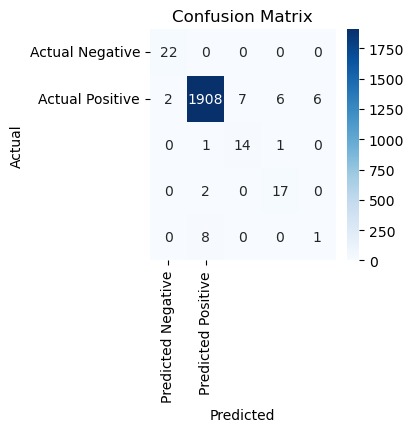

In [851]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 1: Retrieve the best model
best_model = grid.best_estimator_

# Step 2: Predict on the test data
y_pred = best_model.predict(X_test)

# Step 3: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


# Deployment

In [ ]:
with open('../predictive-maintenance/model.pkl', 'wb') as model_file:
    pickle.dump(tuned_model, model_file)

# Conclusion

Predictive maintenance is a strategic approach that aims to anticipate and prevent failures in equipment and machinery, increasing operational efficiency and reducing costs. Within the scope of my data science project, I had the opportunity to explore and apply this methodology through a classification algorithm developed to predict the type of failure in a specific dataset.

The dataset used in this project consists of 10,000 data points, with 14 distinct features, including information such as air temperature, process temperature, rotational speed, torque, tool wear, and a label indicating whether the machine failed or not. Although it was not originally designed for predictive maintenance purposes, I realized that it presented valuable elements for this purpose.

By applying advanced machine learning techniques, I was able to train a classification algorithm capable of predicting the type of failure in a specific process. By utilizing the parameters available in the dataset, such as tool wear, temperature, and torque, the developed model was able to provide insights into the different failure modes that could occur.

This predictive approach enables proactive decision-making regarding maintenance, allowing interventions to be made before a failure occurs. This, in turn, helps to avoid unplanned downtime and reduce costs associated with corrective maintenance.

In summary, the application of predictive maintenance through the classification algorithm developed in this project showcases my knowledge and ability to utilize advanced data science techniques to solve real-world problems. This experience strengthens my portfolio, highlighting my ability to apply data analysis and machine learning to improve operational efficiency and reduce costs in maintenance processes.